# Проверка метрик на синтетических данных

## Реальные данные + аберрация

Извлекаем "самые лучшие" регионы из HG001 и вносим в них искусственные помехи —   
"ступеньку" произвольного размера в произвольном положении

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, os, sys, requests

def load_sample(name):
    dt = pd.read_csv(f'{os.getcwd()}/../../data/GIAB/_las_noappr/{name}_p14.lasbed', sep=' ')
    dt['Name'] = name
    return dt

LB = pd.concat([load_sample(f'HG00{i}') for i in [1]])
LB = LB[LB['covered_bases'] > 0]

In [2]:
def separate(T):
    V = [{
      'good': T.loc[(T['covered_bases'] == 1) & (T['acent'] == 0)],
      'bad':  T.loc[(T['covered_bases'] < 1) | (T['acent'] > 0)]
    }]
    V.append({
      'good': V[0]['good'][V[0]['good']['all_diff'] <= 0.8],
      'bad':  V[0]['good'][V[0]['good']['all_diff'] > 0.8]
    })
    V.append({
      'good': V[1]['good'][V[1]['good']['lc_vcf'] == 0],
      'bad':  V[1]['good'][V[1]['good']['lc_vcf'] > 0]
    })
    V.append({
      'good': V[2]['good'][V[2]['good']['hc_vcf'] <= 0.1],
      'bad':  V[2]['good'][V[2]['good']['hc_vcf'] > 0.1]
    })
    return V

In [3]:
SLB = separate(LB)
G = SLB[3]['good']

In [4]:
SG = G.loc[(G['Std'] < 0.14) & (G['FFT_dF'] < 1250) & (G['DTCWT_Entropy'] > 9.25) & (G['all_diff'] < 0.05)]
len(SG)

65

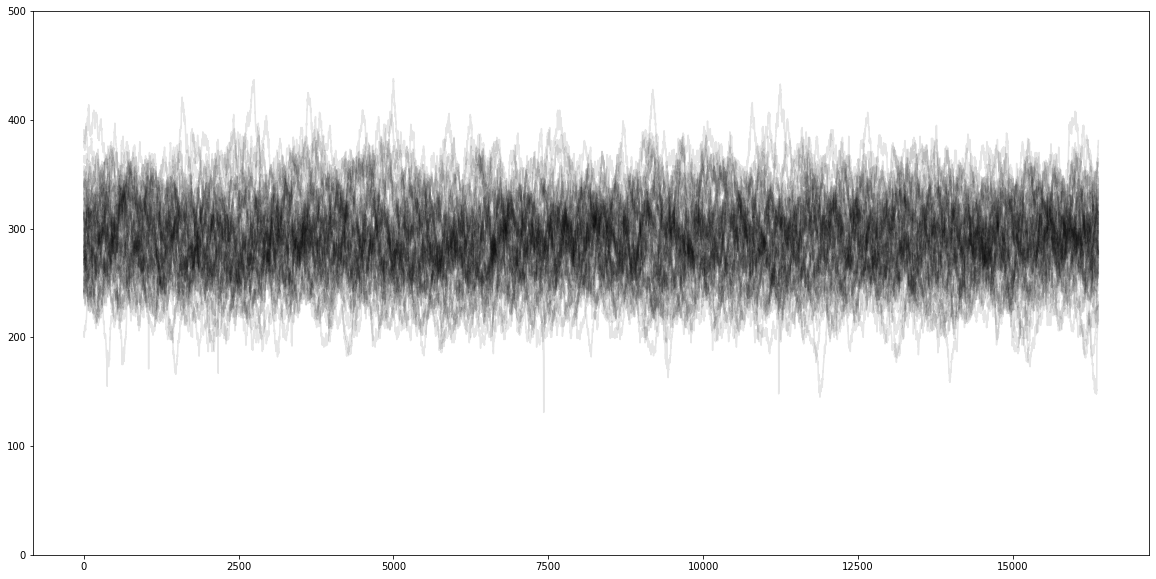

In [7]:
pos = SG.filter(items=['#chr', 'start', 'end']).values.tolist()
sig = requests.post(f'http://127.0.0.1:9950/depth/HG001', json=pos).json()
plt.figure(figsize=(20, 10))
plt.ylim(0,500)
for one in sig:
    plt.plot(one, alpha=0.1, color='#000')

In [10]:
with open(f'{os.getcwd()}/../../data/GIAB/the_best_of_the_best_regions.json', 'w') as f:
    json.dump(sig, f)

## Броуновское движение как хорший сигнал

In [48]:
from math import sqrt
from scipy.stats import norm
import numpy as np

def brownian(x0, n, dt, delta, out=None):
    x0 = np.asarray(x0)
    r = norm.rvs(size=x0.shape + (n,), scale=delta*sqrt(dt))
    if out is None: out = np.empty(r.shape)
    np.cumsum(r, axis=-1, out=out)
    out += np.expand_dims(x0, axis=-1)
    return out

# SRC: https://scipy-cookbook.readthedocs.io/items/BrownianMotion.html

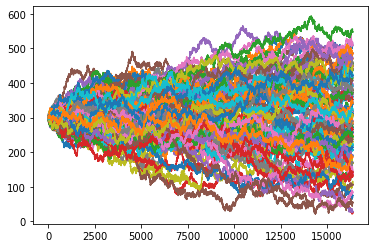

92


In [51]:
N = 2**14
m = 100
x = numpy.empty((m, N+1))
x[:, 0] = 300
brownian(x[:,0], 2**14, 1, 1, out=x[:,1:])

res = []
for sig in x:
    if sig.min() < 20: continue
    if sig.max() > 600: continue
    res.append([int(v) for v in sig])
    plt.plot(sig)

plt.show()
print(len(res))
with open(f'{os.getcwd()}/../../data/GIAB/brownian_regions.json', 'w') as f:
    json.dump(res, f)

## Белый шум

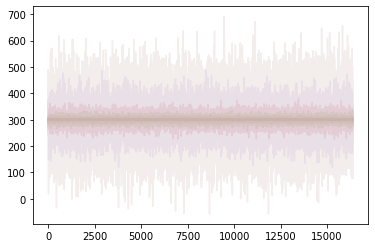

In [60]:
for i in [1, 5, 10, 20, 50, 100]:
    sig = np.random.normal(300, i, size=2**14)
    plt.plot(sig, alpha=0.1)

Пример ступеньки:

(0.0, 1.1)

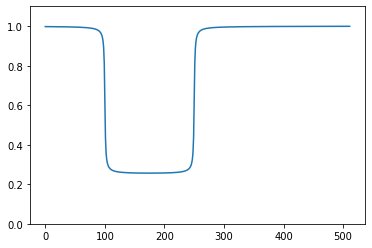

In [11]:
xx = np.arange(0, 2**9, 1)
yy = [1 - (np.arctan(i-100)/(np.pi) + 0.5) * (np.arctan(-(i-250))/(np.pi) + 0.5) * 0.75 for i in xx]
plt.plot(xx, yy)
plt.ylim(0,1.1)

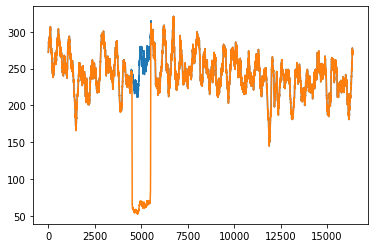

In [12]:
def modify(s, size, position):
    l, r = (position - size/2, position + size/2)
    xx = np.arange(0, len(s), 1)
    yy = [1 - (np.arctan(i-l)/(np.pi) + 0.5) * (np.arctan(-(i-r))/(np.pi) + 0.5) * 0.75 for i in xx]
    return s * np.array(yy)

plt.plot(sig[0])
plt.plot(modify(sig[0], 1000, 5000))

Параллельный запуск проверки метрики на синтетических данных:

```bash
cd PyLas/tools
for size in 256 512 1024 2048 4096 8192; do
  python3 synthetic_test.py ../../data/GIAB/the_best_of_the_best_regions.json \
    $size ../../data/GIAB/best.${size}.json &
  python3 synthetic_test.py ../../data/GIAB/brownian_regions.json \
    $size ../../data/GIAB/brownian.${size}.json &
done;
wait

for scale in 40 50 60 70 80 90 100; do
  python3 synthetic_normal.py $scale ../../data/GIAB/ndist.${scale}.json &
done;
wait
```

In [52]:
# Графики в Mathematica

In [64]:
s_mod = np.random.normal(300, 10, size=2**14)/300
np.std(s_mod)

0.0331225981379589

In [67]:
s_mod = np.random.normal(300, 50, size=2**14)/300
np.std(s_mod)

0.16626837585501061